In [1]:
# !nvidia-smi

Tue May 19 20:16:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 1.x
import tensorflow as tf 
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


**Initialize**

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
import time
import os
from google.colab import files
import shutil

read_file=scipy.io.loadmat('Example_database.mat') # Please put Example_database.mat in right position
Input_train = np.zeros((3360,450,4))  # 80% for train data (total is 4200)
Input_test = np.zeros((840,450,4))   # 20% for test data (total is 4200)
Valid_set = np.zeros((840,450,4)) # Far validation set
Valid_set_close = np.zeros((840,450,4)) # Close validation set

# Assign train data from Example_database.mat
Input_train =np.array(read_file['train_1'])

# Assign test data from Example_database.mat
Input_test =np.array(read_file['test_1'])

# Assign far validation data from Example_database.mat
Valid_set =np.array(read_file['valid_Input'])

# Assign close validation data from Example_database.mat
Valid_set_close =np.array(read_file['valid_Input_close'])

train_label =np.array(read_file['train_label'])  
test_label =np.array(read_file['test_label'])  
valid_label = np.array(read_file['valid_label'])

X_train = Input_train
Y_train = train_label

X_test = Input_test
Y_test = test_label

# Number of classes
n_classes= 42
# Number of features
n_features=X_train.shape[1]



**Set Target Subject**

In [4]:
ID = 1 # Set True user ID (1~42)

print('ID',ID)

Y_train[np.where(Y_train!=ID)] = 0
Y_test[np.where(Y_test!=ID)] = 0
valid_label[np.where(valid_label!=ID)] = 0

ID 1


In [5]:
print(np.unique(Y_train, return_counts=True)) # Check whether train target is only 1 while others are 0
print(np.unique(Y_test, return_counts=True)) # Check whether test target is only 1 while others are 0
print(np.unique(valid_label, return_counts=True)) # Check whether valid target is only 1 while others are 0

(array([0, 1], dtype=uint8), array([3283,   77]))
(array([0, 1], dtype=uint8), array([817,  23]))
(array([0, 1], dtype=uint8), array([820,  20]))


**Onehot encoding + Data spliting and suffle**

In [0]:
enc = OneHotEncoder()
# randomly shuffle data before training and testing

randIndx = np.arange(X_train.shape[0])
np.random.shuffle(randIndx)

randIndx2 = np.arange(X_test.shape[0])
np.random.shuffle(randIndx2)

randIndx3 = np.arange(Valid_set.shape[0])
np.random.shuffle(randIndx3)

trainSamples=np.floor(X_train.shape[0]).astype(int)
testSamples=np.floor(X_test.shape[0]).astype(int) 
validSamples=np.floor(Valid_set.shape[0]).astype(int) 

X_train = X_train[randIndx,:,:] # Shuffle train data
X_test = X_test[randIndx2,:,:] # Shuffle test data
Valid_set = Valid_set[randIndx3,:,:] # Shuffle far validation data
Valid_set_close = Valid_set_close[randIndx3,:,:] # Shuffle close validation data

Y_train =enc.fit_transform(Y_train[randIndx].reshape(-1,1)).toarray() # Shuffle train target with one-hot encoding
Y_test =enc.fit_transform(Y_test[randIndx2].reshape(-1,1)).toarray() # Shuffle test target with one-hot encoding
valid_label =enc.fit_transform(valid_label[randIndx3].reshape(-1,1)).toarray() # Shuffle validation target with one-hot encoding


In [7]:
# Assign to train_data (target) / test_data (target)
train_data, train_target = X_train, Y_train
test_data, test_target = X_test, Y_test

print(train_data.shape,train_target.shape)
print(test_data.shape,test_target.shape)


(3360, 450, 4) (3360, 2)
(840, 450, 4) (840, 2)


**Network Structure**

In [0]:
class Model:

    def __init__(self, sess, name):

        self.sess = sess

        self.name = name

        self._build_net()

    def _build_net(self):

        with tf.variable_scope(self.name):

            self.training = tf.placeholder(tf.bool) # For turn-on/off dropout layer

            # Input place holders
            self.X = tf.placeholder(tf.float32, [None, 450, 1]) # train/validation/test data
            self.Y = tf.placeholder(tf.float32, [None, 2]) # train/validation/test target
            self.learning_rate = tf.placeholder(tf.float32) # learning rate
            self.class_weights = tf.placeholder(tf.float32) # weight value for weighted-cross entropy
            self.reg_constant = tf.placeholder(tf.float32) # regularization constant

            # Convolutional Layer #1, length: 450x1 -> 271x50 (change of feature size)
            W1 = tf.Variable(tf.random_normal([180, 1, 50], stddev=0.01))
            conv1 = tf.nn.conv1d(self.X, W1, stride=1, padding='VALID')
            selu1 = tf.nn.selu(conv1) 
            dropout1 = tf.layers.dropout(inputs=selu1, rate=0.5, training=self.training)
            
            # Convolutional Layer #2, length: 271x50 -> 62x70 (change of feature size)
            W2 = tf.Variable(tf.random_normal([210, 50, 70], stddev=0.01))
            conv2 = tf.nn.conv1d(dropout1, W2, stride=1, padding='VALID')
            selu2 = tf.nn.selu(conv2)                                    
            dropout2 = tf.layers.dropout(inputs=selu2, rate=0.5, training=self.training)
            
        
            # FC layer, length: 62x70  -> 2 output (change of feature size)
            FC1 = tf.reshape(dropout2, [-1, 62*70])  
            FC_weight = tf.get_variable("FC_weight", shape=[62*70, 2], initializer=tf.contrib.layers.xavier_initializer())
            logits = tf.matmul(FC1,FC_weight) # Logit value
    
        # Define cost/loss & optimizer 
        reg_losses = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(FC_weight) # L2 regularization
        
        self.cost = tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.Y, logits, self.class_weights)) 
        self.cost = self.cost + self.reg_constant * reg_losses

        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost) 

        self.sigmoid_out = tf.nn.sigmoid(logits) 
        self.predict = tf.cast(self.sigmoid_out[:,1], tf.float32) # Used for getting final predictions
                    
        
    def get_predict(self, x_test, training = False):          

        return self.sess.run(self.predict, feed_dict={self.X: x_test, self.training: training})
    

    def get_cost(self, x_valid, y_valid, weights, reg, training = False):
        
        return self.sess.run(self.cost, feed_dict={self.X: x_valid, 
                                                   self.Y: y_valid, self.class_weights: weights, self.training: training, self.reg_constant: reg})


    def train(self, x_data, y_data, weights, learning, reg, training = True):

        return self.sess.run(self.optimizer, feed_dict={
             self.X: x_data, self.Y: y_data, self.class_weights: weights, self.learning_rate: learning, self.training: training, self.reg_constant: reg})
    

**Main**

In [9]:
### Hyperparameters

learning_rate = 0.0001
training_epochs = 60
batch_size = 336 # Mini-batch size: total: 3360(train)/840(test) 
num_cv = 10  # 10-fold cross validation
bag_size = 3024  # Bag_size = train_data_size - batch_size
ear_epoch = 0

valid_cost = np.zeros((training_epochs,4))

# initialize
sess = tf.Session()

models = []
num_models = 4 

for m in range(num_models):
    print('Number of Model {}'.format(m+1))
    models.append(Model(sess, "model" + str(m)))    


sess.run(tf.global_variables_initializer())


start_time = time.time() # Time starts!

print('Learning Started!')

# Train model
for epoch in range(training_epochs):
         
    total_batch = int(bag_size / batch_size)
    valid_cost_cv = [0,0,0,0]
    
    cv = KFold(n_splits=num_cv, shuffle=True)
    for train_index, test_index in cv.split(train_data): # For cross validation
        cv_train_data, cv_validate_data = train_data[train_index], train_data[test_index]
        cv_train_target, cv_validate_target = train_target[train_index], train_target[test_index]    
                    
        for m_idx, m in enumerate(models):
            # Assign different regularization constant. They are best hyperparameters from our searching.
            if m_idx==0: # DW feature
              training, validating = cv_train_data[:,:,0], cv_validate_data[:,:,0]
              training_target, validating_target = cv_train_target, cv_validate_target
              reg = 0.02 
            if m_idx==1: # TP feature
              training, validating = cv_train_data[:,:,1], cv_validate_data[:,:,1]
              training_target, validating_target = cv_train_target, cv_validate_target
              reg = 0.01            
            if m_idx==2: # FP feature
              training, validating = cv_train_data[:,:,2], cv_validate_data[:,:,2]
              training_target, validating_target = cv_train_target, cv_validate_target            
              reg = 0.02
            if m_idx==3: # Cubic feature
              training, validating = cv_train_data[:,:,3], cv_validate_data[:,:,3]
              training_target, validating_target = cv_train_target, cv_validate_target            
              reg = 0.01   

            training = np.reshape(training,[len(training),n_features,1])
            validating = np.reshape(validating,[len(validating),n_features,1])

            for i in range(total_batch):

                batch_xs, batch_ys = training[batch_size*i:batch_size*(i+1),:,:], training_target[batch_size*i:batch_size*(i+1)]                
                pos_weight = (n_classes - 1) # Weight value for weighted-cross entropy

                _ = m.train(batch_xs, batch_ys, pos_weight, learning_rate, reg)  # Train model independently
            
            pos_weight = 1 # Usual cross entropy for validation/test set
            valid_cost_cv[m_idx] += m.get_cost(validating, validating_target, pos_weight, reg) 
            
    valid_cost[epoch] =np.divide(valid_cost_cv ,num_cv) # Cost for cross-validation
    
    if ((epoch+1)%5) == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'Model 0_cost =', round(valid_cost[epoch,0],3),' Model 1_cost =', round(valid_cost[epoch,1],3),' Model 2_cost =', round(valid_cost[epoch,2],3),' Model 3_cost =', round(valid_cost[epoch,3],3)) 
       
        
print('Learning Finished!')

end_time = time.time() # Time ends!

train_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(train_time))
print('Last validation error for DW: {:.3f} '.format(valid_cost[-1,0]))
print('Last validation error for TP: {:.3f} '.format(valid_cost[-1,1]))
print('Last validation error for FP: {:.3f} '.format(valid_cost[-1,2]))
print('Last validation error for Cubic: {:.3f} '.format(valid_cost[-1,3]))


Number of Model 1
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Number of Model 2
Number of Model 3
Number of Model 4
Learning Started!
Epoch: 0005 Model 0_cost = 0.763  Model 1_cost = 0.662  Model 2_cost = 0.77  Model 3_cost = 0.449
Epoch: 0010 Model 0_cost = 0.5  Model 1_cost = 0.455  Model 2_cost = 0.55  Model 3_cost = 0.33
Epoch: 0015 Model 0_cost = 0.325  Model 1_cost = 0.349  Model 2_cost = 0.4  Model 3_cost = 0.261
Epoch: 0020 Model 0_cost = 0.22  Model 1_cost = 0.27  Model 2_cost = 0.292  Model 3_cost = 0.206
Epoch: 0025 Model 0_cost = 

**Epoch vs Cost plot**

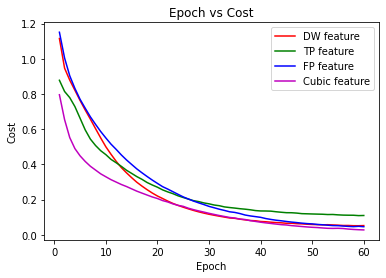

In [10]:
fig = plt.figure()
ax = plt.subplot(111)

x_axis = np.linspace(1.0, training_epochs, num=training_epochs)
ax.plot(x_axis, valid_cost[:,0],'r', label='DW feature')
ax.plot(x_axis, valid_cost[:,1],'g', label='TP feature')
ax.plot(x_axis, valid_cost[:,2],'b', label='FP feature')
ax.plot(x_axis, valid_cost[:,3],'m', label='Cubic feature')

ax.legend()
plt.title('Epoch vs Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')

plt.show()

**Performance from far and close validation sets**


In [0]:
thres = np.arange(0, 1.001, 0.001)

valid_0 = np.reshape(Valid_set[:,:,0], [len(Valid_set[:,:,0]),n_features,1])
valid_1 = np.reshape(Valid_set[:,:,1], [len(Valid_set[:,:,1]),n_features,1])
valid_2 = np.reshape(Valid_set[:,:,2], [len(Valid_set[:,:,2]),n_features,1])
valid_3 = np.reshape(Valid_set[:,:,3], [len(Valid_set[:,:,3]),n_features,1])

valid_close_0 = np.reshape(Valid_set_close[:,:,0], [len(Valid_set_close[:,:,0]),n_features,1])
valid_close_1 = np.reshape(Valid_set_close[:,:,1], [len(Valid_set_close[:,:,1]),n_features,1])
valid_close_2 = np.reshape(Valid_set_close[:,:,2], [len(Valid_set_close[:,:,2]),n_features,1])
valid_close_3 = np.reshape(Valid_set_close[:,:,3], [len(Valid_set_close[:,:,3]),n_features,1])

start_time_valid = time.time() # Time starts!    

valid_logit_0 =  models[0].get_predict(valid_0) # Far-validation score in Model-DW feature
valid_logit_1 =  models[1].get_predict(valid_1) # Far-validation score in Model-TP feature
valid_logit_2 =  models[2].get_predict(valid_2) # Far-validation score in Model-FP feature
valid_logit_3 =  models[3].get_predict(valid_3) # Far-validation score in Model-Cubic feature

valid_close_logit_0 =  models[0].get_predict(valid_close_0) # Close-validation score in Model-DW feature
valid_close_logit_1 =  models[1].get_predict(valid_close_1) # Close-validation score in Model-TP feature
valid_close_logit_2 =  models[2].get_predict(valid_close_2) # Close-validation score in Model-FP feature
valid_close_logit_3 =  models[3].get_predict(valid_close_3) # Close-validation score in Model-Cubic feature


In [0]:
# Far-validation result in Model-DW feature

thres_matrix_valid_0 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_0 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_logit_0[i] < thres[j]:
            thres_matrix_valid_0[i,j] = 0
        else:
            thres_matrix_valid_0[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_0[:,i], valid_label[:,1])
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_0[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_0[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_0[i,:] = ACC_test, FAR_test, FRR_test, Recall_test


EER_loc_test = np.argmin(abs(total_matrix_valid_0[:,1] - total_matrix_valid_0[:,2]))
EER_0 = (total_matrix_valid_0[EER_loc_test,1]+total_matrix_valid_0[EER_loc_test,2])/2

In [0]:
# Far-validation result in Model-TP feature

thres_matrix_valid_1 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_1 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_logit_1[i] < thres[j]:
            thres_matrix_valid_1[i,j] = 0
        else:
            thres_matrix_valid_1[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_1[:,i], valid_label[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_1[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_1[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_1[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_1[:,1] - total_matrix_valid_1[:,2]))
EER_1 = (total_matrix_valid_1[EER_loc_test,1]+total_matrix_valid_1[EER_loc_test,2])/2

In [0]:
# Far-validation result in Model-FP feature

thres_matrix_valid_2 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_2 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_logit_2[i] < thres[j]:
            thres_matrix_valid_2[i,j] = 0
        else:
            thres_matrix_valid_2[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_2[:,i], valid_label[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_2[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_2[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_2[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_2[:,1] - total_matrix_valid_2[:,2]))
EER_2 = (total_matrix_valid_2[EER_loc_test,1]+total_matrix_valid_2[EER_loc_test,2])/2

In [0]:
# Far-validation result in Model-Cubic feature

thres_matrix_valid_3 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_3 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_logit_3[i] < thres[j]:
            thres_matrix_valid_3[i,j] = 0
        else:
            thres_matrix_valid_3[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_3[:,i], valid_label[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_3[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_3[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_3[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_3[:,1] - total_matrix_valid_3[:,2]))
EER_3 = (total_matrix_valid_3[EER_loc_test,1]+total_matrix_valid_3[EER_loc_test,2])/2

valid_per = [EER_0, EER_1, EER_2, EER_3] # EER results from far-validation set in each model

for i in range(len(valid_per)): # If EER is 0, give 0.001 instead to avoid NaN
	if valid_per[i] ==0:
		valid_per[i] = 0.001


In [0]:
# Close-validation result in Model-DW feature

thres_matrix_valid_close_0 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_close_0 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_close_logit_0[i] < thres[j]:
            thres_matrix_valid_close_0[i,j] = 0
        else:
            thres_matrix_valid_close_0[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_close_0[:,i], valid_label[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_close_0[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_close_0[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_close_0[i,:] = ACC_test, FAR_test, FRR_test, Recall_test


EER_loc_test = np.argmin(abs(total_matrix_valid_close_0[:,1] - total_matrix_valid_close_0[:,2]))
EER_close_0 = (total_matrix_valid_close_0[EER_loc_test,1]+total_matrix_valid_close_0[EER_loc_test,2])/2


In [0]:
# Close-validation result in Model-TP feature

thres_matrix_valid_close_1 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_close_1 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_close_logit_1[i] < thres[j]:
            thres_matrix_valid_close_1[i,j] = 0
        else:
            thres_matrix_valid_close_1[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_close_1[:,i], valid_label[:,1])
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_close_1[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_close_1[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_close_1[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_close_1[:,1] - total_matrix_valid_close_1[:,2]))
EER_close_1 = (total_matrix_valid_close_1[EER_loc_test,1]+total_matrix_valid_close_1[EER_loc_test,2])/2

In [0]:
# Close-validation result in Model-FP feature

thres_matrix_valid_close_2 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_close_2 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_close_logit_2[i] < thres[j]:
            thres_matrix_valid_close_2[i,j] = 0
        else:
            thres_matrix_valid_close_2[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_close_2[:,i], valid_label[:,1])
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_close_2[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_close_2[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_close_2[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_close_2[:,1] - total_matrix_valid_close_2[:,2]))
EER_close_2 = (total_matrix_valid_close_2[EER_loc_test,1]+total_matrix_valid_close_2[EER_loc_test,2])/2

In [0]:
# Close-validation result in Model-Cubic feature

thres_matrix_valid_close_3 = np.zeros((len(valid_label),len(thres)))
total_matrix_valid_close_3 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)


for j in range(len(thres)):
    for i in range(len(valid_label)):
        if valid_close_logit_3[i] < thres[j]:
            thres_matrix_valid_close_3[i,j] = 0
        else:
            thres_matrix_valid_close_3[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_valid_close_3[:,i], valid_label[:,1])
    unique2, True_pos_neg_test = np.unique(thres_matrix_valid_close_3[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_valid_close_3[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(valid_label))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_valid_close_3[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

EER_loc_test = np.argmin(abs(total_matrix_valid_close_3[:,1] - total_matrix_valid_close_3[:,2]))
EER_close_3 = (total_matrix_valid_close_3[EER_loc_test,1]+total_matrix_valid_close_3[EER_loc_test,2])/2

# EER results from close-validation set in each model
valid_close_per = [EER_close_0, EER_close_1, EER_close_2, EER_close_3] 
	
for i in range(len(valid_close_per)): # If EER is 0, give 0.001 instead to avoid NaN
	if valid_close_per[i] ==0:
		valid_close_per[i] = 0.001		

valid_time = time.time() - start_time_valid # Time for calculating far and close validation sets

**Results of test set in individual model**

In [0]:
testing_0 = np.reshape(test_data[:,:,0], [len(test_data[:,:,0]),n_features,1])
testing_1 = np.reshape(test_data[:,:,1], [len(test_data[:,:,1]),n_features,1])
testing_2 = np.reshape(test_data[:,:,2], [len(test_data[:,:,2]),n_features,1])
testing_3 = np.reshape(test_data[:,:,3], [len(test_data[:,:,3]),n_features,1])

start_time_test2 = time.time() # Time starts!    

test_logit_0 =  models[0].get_predict(testing_0) # Test score in Model-DW feature
test_logit_1 =  models[1].get_predict(testing_1) # Test score in Model-TP feature
test_logit_2 =  models[2].get_predict(testing_2) # Test score in Model-FP feature
test_logit_3 =  models[3].get_predict(testing_3) # Test score in Model-Cubic feature    

test_all_logit = np.array([test_logit_0, test_logit_1, test_logit_2, test_logit_3])

test_time = time.time() - start_time_test2  # Time for predicting in each model

**Variation-stable approach with assigning weights**

In [21]:
start_time_vari = time.time() # Time starts!    

diff_value = abs(np.subtract(valid_per,valid_close_per)) # Calculate the difference between validation sets

vari_valid_per = []
vari_loc = []

if np.std(diff_value) >= 0.17: # Check whether std. of difference is over 0.17
	for i in range(len(diff_value)):
		if diff_value[i] < 0.25: # Include model if its difference of validation sets is less than 0.25
			vari_valid_per.append(valid_close_per[i])
			vari_loc.append(i)

else: 
	vari_valid_per = valid_close_per # If std. of difference is less than 0.17, use close (or far) validation set
	vari_loc = [0,1,2,3]

# Calculate the weight values using EER values from close (or far) validation set in remained models
vari_weight = []
for i in range(len(vari_valid_per)): 
	vari_weight.append(round(np.divide((1/vari_valid_per[i]) ,(np.sum(np.divide(1,vari_valid_per)))), 3))
	
print('Std. of difference between validation sets: ',np.std(diff_value))
print('Weights in variation fusion: ',vari_weight)

vari_time = time.time() - start_time_vari

Std. of difference between validation sets:  0.11582439344753585
Weights in variation fusion:  [0.371, 0.031, 0.371, 0.226]


**Variation - Min Fusion**

In [22]:
start_time_min = time.time() # Time starts!    

thres_matrix_fusion = np.zeros((len(test_target),len(thres)))
total_matrix_fusion = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)

vari_min_test_logit = test_all_logit[vari_loc[vari_valid_per.index(min(vari_valid_per))],:]

for j in range(len(thres)):
    for i in range(len(test_target)):
        if vari_min_test_logit[i] < thres[j]:
            thres_matrix_fusion[i,j] = 0
        else:
            thres_matrix_fusion[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_fusion[:,i], test_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_fusion[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_fusion[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_fusion[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

min_time = time.time() - start_time_min

elapsed = train_time + test_time + valid_time + vari_time + min_time

print('Execution time for variation - min fusion: {:.2f} seconds'.format(elapsed))

Execution time for variation - min fusion: 364.93 seconds


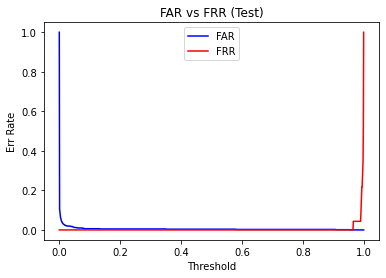

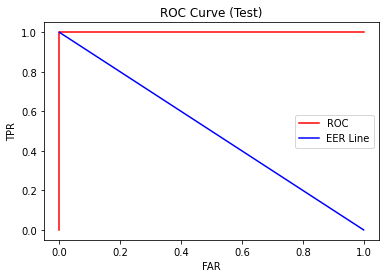

EER with variation - min fusion: 0.000 
Accuracy with variation - min fusion: 1.000 


In [23]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_fusion[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_fusion[:,2],'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Test)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_fusion[:,1], total_matrix_fusion[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Test)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_fusion[:,1] - total_matrix_fusion[:,2]))
print('EER with variation - min fusion: {:.3f} '.format((total_matrix_fusion[EER_loc_test,1]+total_matrix_fusion[EER_loc_test,2])/2))
print('Accuracy with variation - min fusion: {:.3f} '.format(total_matrix_fusion[EER_loc_test,0]))

**Variation - Sum Fusion**

In [24]:
start_time_sum = time.time() # Time starts!    

thres_matrix_fusion2 = np.zeros((len(test_target),len(thres)))
total_matrix_fusion2 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)

vari_sum_test_logit = np.zeros(np.shape(test_all_logit[0,:]))

for i in range(len(vari_loc)):
	vari_sum_test_logit += vari_weight[i] * test_all_logit[vari_loc[i],:]

for j in range(len(thres)):
    for i in range(len(test_target)):
        if vari_sum_test_logit[i] < thres[j]:
            thres_matrix_fusion2[i,j] = 0
        else:
            thres_matrix_fusion2[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_fusion2[:,i], test_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_fusion2[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_fusion2[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_fusion2[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

sum_time = time.time() - start_time_sum  

elapsed = train_time + test_time + valid_time + vari_time + sum_time

print('Execution time for variation - sum fusion: {:.2f} seconds'.format(elapsed))


Execution time for variation - sum fusion: 363.57 seconds


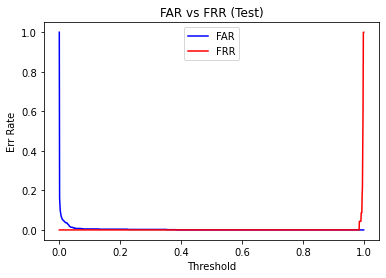

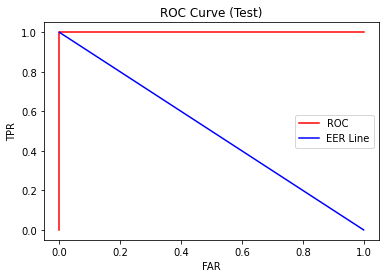

EER with variation - sum fusion: 0.000 
Accuracy with variation - sum fusion: 1.000 


In [25]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_fusion2[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_fusion2[:,2],'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Test)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_fusion2[:,1], total_matrix_fusion2[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Test)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_fusion2[:,1] - total_matrix_fusion2[:,2]))
print('EER with variation - sum fusion: {:.3f} '.format((total_matrix_fusion2[EER_loc_test,1]+total_matrix_fusion2[EER_loc_test,2])/2))
print('Accuracy with variation - sum fusion: {:.3f} '.format(total_matrix_fusion2[EER_loc_test,0]))

**Variation - Product Fusion**

In [26]:
start_time_product = time.time() # Time starts!    

thres_matrix_fusion3 = np.zeros((len(test_target),len(thres)))
total_matrix_fusion3 = np.zeros((len(thres),4)) #acc,far,frr,recall(order of column)

vari_product_test_logit = np.ones(np.shape(test_all_logit[0,:]))

for i in range(len(vari_loc)):
	vari_product_test_logit = np.multiply(vari_product_test_logit, np.power(test_all_logit[vari_loc[i],:],vari_weight[i]))

for j in range(len(thres)):
    for i in range(len(test_target)):
        if vari_product_test_logit[i] < thres[j]:
            thres_matrix_fusion3[i,j] = 0
        else:
            thres_matrix_fusion3[i,j] = 1

for i in range(len(thres)):

    equal_logit = np.equal(thres_matrix_fusion3[:,i], test_target[:,1]) 
    unique2, True_pos_neg_test = np.unique(thres_matrix_fusion3[np.where(equal_logit==True),i], return_counts=True)
    unique3, False_pos_neg_test = np.unique(thres_matrix_fusion3[np.where(equal_logit==False),i], return_counts=True) 

    if np.shape(True_pos_neg_test)==(1,):
        if unique2[0] == 0:
            True_pos_neg_test = [True_pos_neg_test[0], 0]
        else:
            True_pos_neg_test = [0, True_pos_neg_test[0]]

    if np.shape(False_pos_neg_test)==(1,):
        if unique3[0] == 0:
            False_pos_neg_test = [False_pos_neg_test[0], 0]
        else:
            False_pos_neg_test = [0, False_pos_neg_test[0]]

    if np.shape(True_pos_neg_test)==(0,):
        True_pos_neg_test = [0, 0]

    if np.shape(False_pos_neg_test)==(0,):
        False_pos_neg_test = [0, 0]

    Recall_test= True_pos_neg_test[1]/(False_pos_neg_test[0]+True_pos_neg_test[1])
    Specific_test = True_pos_neg_test[0] /(True_pos_neg_test[0]+False_pos_neg_test[1])

    ACC_test = (True_pos_neg_test[0]+True_pos_neg_test[1]) / (len(test_target))
    FAR_test = 1 - Specific_test
    FRR_test = 1 - Recall_test

    total_matrix_fusion3[i,:] = ACC_test, FAR_test, FRR_test, Recall_test

product_time = time.time() - start_time_product  

elapsed = train_time + test_time + valid_time + vari_time + product_time

print('Execution time for variation - product fusion: {:.2f} seconds'.format(elapsed))

Execution time for variation - product fusion: 363.57 seconds


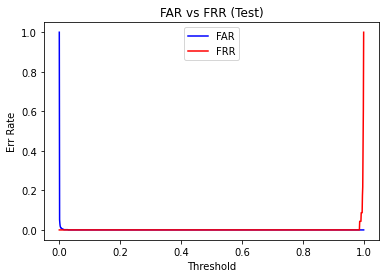

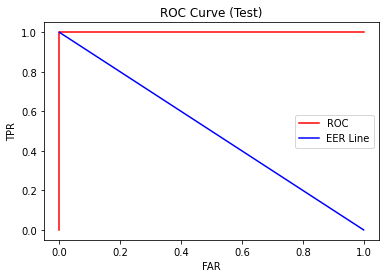

EER with variation - product fusion: 0.000 
Accuracy with variation - product fusion: 1.000 


In [27]:
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(thres, total_matrix_fusion3[:,1], 'b', label='FAR')
ax.plot(thres, total_matrix_fusion3[:,2],'r', label='FRR')
ax.legend()
plt.title('FAR vs FRR (Test)')
plt.xlabel('Threshold')
plt.ylabel('Err Rate')
plt.show()

EER_line = thres[::-1]
fig = plt.figure()
ax2 = plt.subplot(111)
ax2.plot(total_matrix_fusion3[:,1], total_matrix_fusion3[:,3],'r',label='ROC')
ax2.plot(thres, EER_line, 'b',label='EER Line')
ax2.legend()
plt.title('ROC Curve (Test)')
plt.xlabel('FAR')
plt.ylabel('TPR')
plt.show()

EER_loc_test = np.argmin(abs(total_matrix_fusion3[:,1] - total_matrix_fusion3[:,2]))
print('EER with variation - product fusion: {:.3f} '.format((total_matrix_fusion3[EER_loc_test,1]+total_matrix_fusion3[EER_loc_test,2])/2))
print('Accuracy with variation - product fusion: {:.3f} '.format(total_matrix_fusion3[EER_loc_test,0]))